1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

Z= 3.4661629670697414


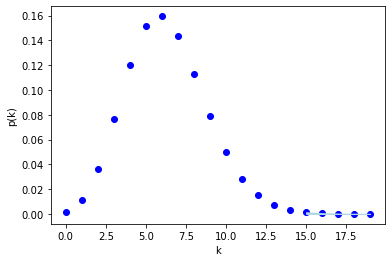

In [2]:
k=np.arange(0,20)
mu=6.3
plt.scatter(k, stats.poisson(mu).pmf(k), color="blue", marker="o")
plt.fill_between(k, stats.poisson(mu).pmf(k), where=(k>14), color='lightblue')
plt.xlabel("k")
plt.ylabel("p(k)")
k15= 15
Z=(15-mu)/np.sqrt(mu)
print("Z=",Z)

In [3]:
p15=1-np.sum([stats.poisson(mu=6.3).pmf(k) for k in range(0,15)])
print("the probability of having 15 hurricanes in one year is:",p15)

the probability of having 15 hurricanes in one year is: 0.002217122790073467


2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [4]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135]) 

In [5]:
stdpre = np.std(pre)
stdpost = np.std(post)
std = np.sqrt((stdpre**2 + stdpost**2)/2) 
T = (np.average(pre) - np.average(post)) / (std * np.sqrt(2/len(post)))
print('T = ', T, 'pvalue = ', stats.t.cdf(T, len(post)-1))
#hence statistically non significant

T =  -3.991846326292112 pvalue =  0.0015744704677267873


3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

Text(0, 0.5, 'year')

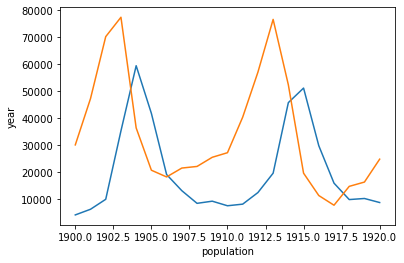

In [6]:
import pandas as pd
year, hare, lynx, carrots = np.loadtxt('populations.txt', unpack = True) 
plt.plot(year, lynx,label = 'lynx')
plt.plot(year, hare, label = 'hare')
plt.xlabel('population')
plt.ylabel('year')

max frequency for lynx (f>0): 0.047619047619047616
max frequency for hare (f>0): 0.047619047619047616
period lynx =  21.0 years
period hare =  21.0 years


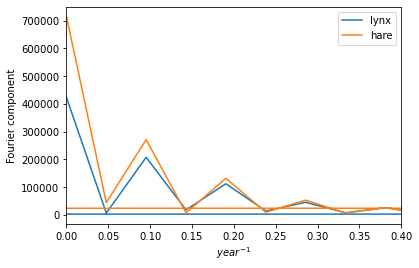

In [7]:
from scipy import fftpack

freq = fftpack.fftfreq(year.size, d=1)
lynx_pow = np.abs(fftpack.fft(list(lynx)))
hare_pow = np.abs(fftpack.fft(list(hare)))

plt.plot(freq, lynx_pow,label = 'lynx')
plt.plot(freq, hare_pow,label = 'hare')
plt.ylabel('Fourier component')
plt.xlim(0.,0.4)
plt.xlabel('$year^{-1}$')
plt.legend()
print("max frequency for lynx (f>0):", freq[lynx_pow[freq>0].argmax()])
print("max frequency for hare (f>0):", freq[hare_pow[freq>0].argmax()])
print('period lynx = ', 1/freq[lynx_pow[freq>0].argmax()], "years")
print('period hare = ', 1/freq[hare_pow[freq>0].argmax()], "years")


4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

Text(0.5, 1.0, 'Image with noise')

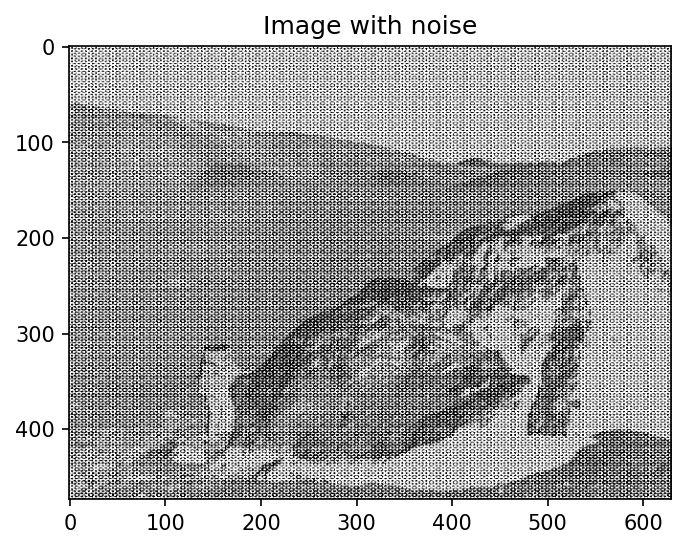

In [8]:
image=plt.imread("moonlanding.png")
plt.figure(dpi=150)
plt.imshow(image, cmap='binary')
plt.title("Image with noise")

Text(0.5, 1.0, 'FFT of the Image')

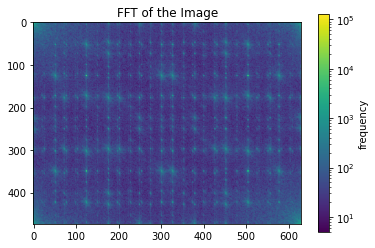

In [9]:
from scipy.fftpack import fft2, ifft2
ft= fft2(image)
#ft_centered = fftpack.fftshift(ft)
from matplotlib.colors import LogNorm
plt.imshow(np.abs(ft), norm=LogNorm(vmin=5))
plt.colorbar(label="frequency")
plt.title("FFT of the Image")

Text(0.5, 1.0, 'FFT of the Image without noise')

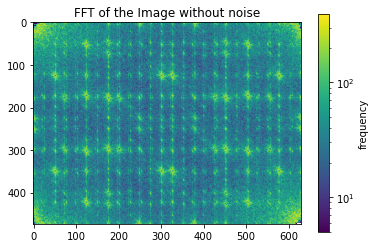

In [10]:
threshold=np.percentile(np.abs(ft), 99.5)
r,l=ft.shape
for i in range(r):
    for j in range(l):
        if np.abs(ft[i,j])>threshold: 
            ft[i,j]=0
            
plt.imshow(np.abs(ft), norm=LogNorm(vmin=5))
plt.colorbar(label="frequency")
plt.title("FFT of the Image without noise")

Text(0.5, 1.0, 'Image without noise')

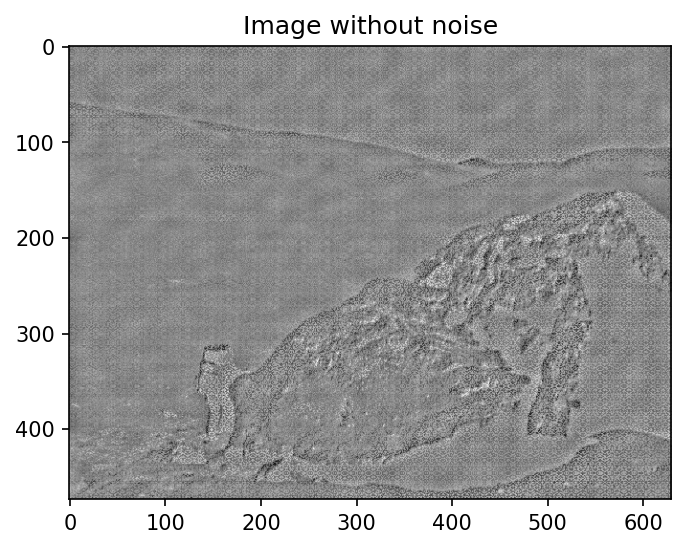

In [11]:
filtered_image=np.real_if_close(ifft2(ft))
plt.figure(dpi=150)
plt.imshow(filtered_image, cmap='binary')
plt.title("Image without noise")